# Agregar y limpiar datos

In [189]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
%matplotlib inline

In [190]:
!ls ./Datos/10-9-extras/

10-9 Nuevos_registros_proveedores-copy - Proveedores nuevos.csv
10-9 donantes_nuevos_registros-copy.xlsx - donantes_nuevos_registros.csv
Donantes - viejos.csv
Donantes.xlsx
Proveedores - Proveedores.csv


In [191]:
# Dataframes
data_prov_old = "./Datos/10-9-extras/Proveedores - Proveedores.csv"
data_donan_old = "./Datos/10-9-extras/Donantes.xlsx"
data_prov = "./Datos/10-9-extras/10-9 Nuevos_registros_proveedores-copy - Proveedores nuevos.csv"
data_donan = "./Datos/10-9-extras/10-9 donantes_nuevos_registros-copy.xlsx - donantes_nuevos_registros.csv"

# old
dfpo = pd.read_csv(data_prov_old)
dfdo = pd.read_excel(data_donan_old, sheet_name="Donantes")
# new
dfpn = pd.read_csv(data_prov)
dfdn = pd.read_csv(data_donan)

#### ***NOTA***
***fecha de alta como fecha de donacion, codigo area como argentina/buenos aires***

---

## Viejo vs nuevo

### Proveedores

In [192]:
sp_old = pd.Series(dfpo.columns.to_list())
sp_new = pd.Series(dfpn.columns.to_list())

display_prov = pd.concat([sp_old, sp_new], axis=1)
print(f"prov_old shape: {dfpo.shape}, prov_new shape: {dfpn.shape}\n")
display_prov.columns = ["Viejos", "Nuevos"]
display_prov

prov_old shape: (150, 12), prov_new shape: (373, 16)



,Viejos,Nuevos
0,Número Proveedor,Número Proveedor
1,Nombre Proveedor,Nombre Proveedor
2,CUIT,CUIT
3,Categoria Proveedor,Categor/a Proveedor
4,Tipo de Contribuyente,Tipo de Contribuyente
5,Contacto,Observaciones
6,Correo Electrónico,Contacto
7,Teléfono,Correo Electrónico
8,Razón Social,Teléfono
9,Importe,Razón Social


### Donantes

In [193]:
sd_old = pd.Series(dfdo.columns.to_list())
sd_new = pd.Series(dfdn.columns.to_list())

display_don = pd.concat([sd_old, sd_new] ,axis=1)
print(f"prov_old shape: {dfdo.shape}, prov_new shape: {dfdn.shape}\n")
display_don.columns = ["Viejos", "Nuevos"]
display_don

prov_old shape: (109, 18), prov_new shape: (499, 19)



,Viejos,Nuevos
0,Número,Numero
1,Nombre,Nombre
2,Tipo,Tipo
3,Contacto,Contacto
4,Cargo,Cargo
5,Correo Electrónico,Correo Electrónico
6,Teléfono,Telefono
7,Observaciones,Observaciones
8,Razon Social,Razon Social
9,Tipo de Contribuyente,Tipo de Contribuyente


In [194]:
display_don.tail(2)

,Viejos,Nuevos
17,Mes,Fecha_Donación
18,NaN,País


La diferencia es en la columna de `Mes` que cree anteriormente y 2 nuevas columnas `Fecha_Donación` y `País`

---

## Un poco de limpieza de los nuevos datos antes de empezar a unir

**Proveedores**

In [195]:
dfpn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Número Proveedor       373 non-null    object 
 1   Nombre Proveedor       373 non-null    object 
 2   CUIT                   373 non-null    object 
 3   Categor/a Proveedor    373 non-null    object 
 4   Tipo de Contribuyente  373 non-null    object 
 5   Observaciones          373 non-null    object 
 6   Contacto               373 non-null    object 
 7   Correo Electrónico     373 non-null    object 
 8   Teléfono               373 non-null    object 
 9   Razón Social           373 non-null    object 
 10  Importe                373 non-null    object 
 11  Fecha                  373 non-null    object 
 12  Nro_Cuenta             373 non-null    int64  
 13  Ciudad                 373 non-null    object 
 14  Pais                   373 non-null    object 
 15  Maps  

#### **NOTA**  
***Samplear distribucion de ciudades, y imputarlas en las columnas que faltan para despues unir los datos, despues generar verdaderos numeros de telefonos en base a la ciudad `+54[area][numero-random-con-sentido]`***

---

Solo la columna Maps esta vacia pero eso lo arreglamos al final

Un vistazo rapido con [_Data Wrangler_](https://code.visualstudio.com/docs/datascience/data-wrangler) podemos ver que solo hay que limpiar 3 columnas  
Algunos `'/'` extras en **Categoria proveedor** y **Tipo de contribuyente**, y algunos `'AR'` extras en los numeros de telefono. Tambien dropeamos la columna **Observaciones** ya que no aporta nada

In [196]:
dfpn_bk = dfpn.copy()

def clean_prov_new(df: pd.DataFrame) -> pd.DataFrame:
  df = df.drop(["Observaciones"], axis=1)
  df.rename(columns={"Categor/a Proveedor": "Categoria Proveedor"}, inplace=True)

  cols_lower = ["Categoria Proveedor", "Tipo de Contribuyente"]
  # aplicamos .lower a nivel de fila en ambas columnas (funciona porque ambas son str)
  df[cols_lower] = df[cols_lower].apply(lambda x: x.str.capitalize())

  ## Piola usando apply pero muy largo, buena oportunidad para mejorar en regex
  # def clean_slash(value):
  #   if "/" in value:
  #     slash = value.index("/")
  #     if value[slash - 1] == "i" or value[slash + 1] == "i":
  #       return value.replace("/", "")
  #     else:
  #       return value.replace("/", "i")
  #   else:
  #     return value
  # df["Categoria Proveedor"] = df["Categoria Proveedor"].apply(clean_slash)
  #
  cl = "Categoria Proveedor"
  df[cl] = df[cl].str.replace("/", "i").str.replace("Materiiales", "Materiales")

  df["Tipo de Contribuyente"] = df["Tipo de Contribuyente"].str.replace("/", "i")
  df["Teléfono"] = df["Teléfono"].str.replace("AR", "")
  return df

In [197]:
# check
dfpn_clean = clean_prov_new(dfpn)
dfpn_clean.sort_values(by=["Teléfono"], ascending=False).head()

,Número Proveedor,Nombre Proveedor,CUIT,Categoria Proveedor,Tipo de Contribuyente,Contacto,Correo Electrónico,Teléfono,Razón Social,Importe,Fecha,Nro_Cuenta,Ciudad,Pais,Maps
11,P00009,Fernando Gómez,30-12345679-8,Materiales,Responsabile inscripto,Fernando Gómez,fernando.gomez@correo.zom,9012-3456,S.A.,"151.274,00",6/03/2024,509100,Mendoza,Argentina,NaN
10,P00009,Fernando Gómez,30-12345679-8,Materiales,Responsabile inscripto,Fernando Gómez,fernando.gomez@correo.zom,9012-3456,S.A.,"12.373,00",20/01/2024,509100,Mendoza,Argentina,NaN
27,P00018,Consultora Zeta,30-19283747-0,Servicios,Responsable inscriito,Laura Sánchez,laura.sanchez@empresa.zom,8901-2345,S.R.L.,"122.441,00",3/01/2024,501400,San Rafael,Argentina,NaN
28,P00018,Consultora Zeta,30-19283747-0,Servicios,Responsable inscriito,Laura Sánchez,laura.sanchez@empresa.zom,8901-2345,S.R.L.,"133.962,00",4/02/2024,501400,San Rafael,Argentina,NaN
8,P00008,Compañía Beta,30-74859632-7,Agente impositivo,Monotributista,Laura Martínez,laura.martinez@empresa.zom,8901-2345,S.R.L.,"110.198,00",12/06/2024,506100,La Plata,Argentina,NaN


In [198]:
dfpn_clean["Categoria Proveedor"].unique()

array(['Servicios', 'Materiales', 'Agente impositivo', 'Tecnología',
       'Consultoría', 'Energía renovable', 'Transporte', 'Construcción',
       'Agroindustria', 'Software', 'Consultoría it', 'Energía eólica',
       'Energía solar'], dtype=object)

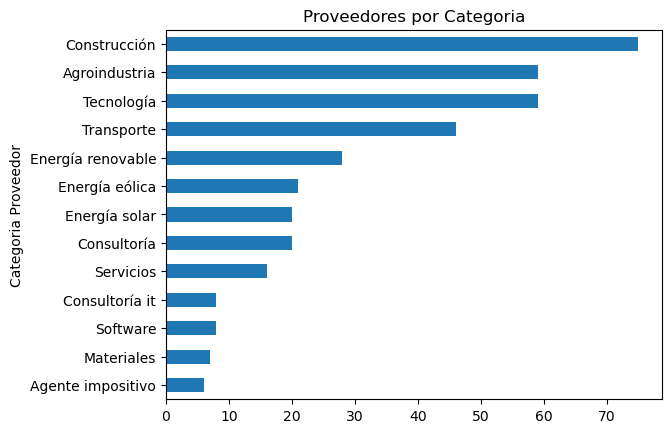

In [199]:
dfpn_clean["Categoria Proveedor"].value_counts() \
  .sort_values(ascending=True) \
  .plot(kind="barh",
         title="Proveedores por Categoria")
plt.show()

**NOTA**: Cambiar los telefonos acorde a los paises

---

## Empezar a acomodar las columnas

**Proveedores**

Primero que nada para evitar unir los datos y que haya datos faltantes en el anterior dataset de 150 registros con los nuevos 373 registros los cuales tienen 3 columnas nuevas, voy a primero agregar esas 3 columnas con 150 registros.  

El campo `Pais` y `Maps` es simple ya que es solo 1 dato, pero en el campo `Ciudad` voy a agarrar la distribucion de las ciudades de los nuevos datos y generar 150 nuevas para despues poder unir todo y que tenga sentido.

In [200]:
# Creamos la distribucion para despues samplearla al agregar las ciudades
ciudad_pd = dfpn_clean["Ciudad"].value_counts().reset_index()
ciudad_pd["Probabilidad"] = ciudad_pd["count"] / ciudad_pd["count"].sum()
ciudad_pd.head()


,Ciudad,count,Probabilidad
0,Buenos Aires,73,0.195710
1,Mendoza,18,0.048257
2,Merlo,16,0.042895
3,Bahía Blanca,14,0.037534
4,Villa María,11,0.029491


Ahora usamos `random.choice` agarrando 150 ciudades basadas en la distribucion

In [201]:
ciudades = ciudad_pd["Ciudad"]
proba = ciudad_pd["Probabilidad"]
size = 150
ciudad_sample = np.random.choice(ciudades, size=size, p=proba)

Agregamos las 3 columnas para despues unir todo a nivel registro

In [202]:
# ciudades
ciudad_col = pd.Series(ciudad_sample)
columns = ["Pais", "Maps"]
cantidad = dfpo.shape[0]
# pais y maps
new_cols = dfpn_clean[columns][:cantidad]

# unimos con los datos viejos

dfp_copy = dfpo.copy()
dfp_copy["Ciudad"] = ciudad_col
dfp_merge = pd.concat([dfp_copy, new_cols], axis=1)
# shape
print(dfp_merge.shape)
dfp_merge.iloc[:, -4:].head()

(150, 15)


,Nro_Cuenta,Ciudad,Pais,Maps
0,509100,Junín,Argentina,NaN
1,503100,Rosario,Argentina,NaN
2,509100,General Roca,Argentina,NaN
3,503100,Viedma,Argentina,NaN
4,516000,San Pedro,Argentina,NaN


In [203]:
# capitalize
cl = "Categoria Proveedor"
dfp_merge[cl] = dfp_merge[cl].apply(lambda x: x.capitalize())
dfp_merge[cl].head()

0      Servicos
1    Materiales
2    Materiales
3      Servicos
4      Servicos
Name: Categoria Proveedor, dtype: object

Ahora directamente unimos todo con `dfpn_clean`

In [204]:
dfpmerge_final = pd.concat([dfpn_clean, dfp_merge], ignore_index=True)
print(dfpmerge_final.shape)
dfpmerge_final.info()

(523, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Número Proveedor       523 non-null    object 
 1   Nombre Proveedor       523 non-null    object 
 2   CUIT                   523 non-null    object 
 3   Categoria Proveedor    523 non-null    object 
 4   Tipo de Contribuyente  523 non-null    object 
 5   Contacto               523 non-null    object 
 6   Correo Electrónico     523 non-null    object 
 7   Teléfono               523 non-null    object 
 8   Razón Social           523 non-null    object 
 9   Importe                523 non-null    object 
 10  Fecha                  523 non-null    object 
 11  Nro_Cuenta             523 non-null    int64  
 12  Ciudad                 523 non-null    object 
 13  Pais                   523 non-null    object 
 14  Maps                   0 non-null      float64
d

Ahora que estan las nuevas filas en las columnas en comun hay que agregar las columnas nuevas